# KerasCV

[![Open in Colab](https://lab.aef.me/files/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/lab/blob/main/files/tf/keras_cv.ipynb)
[![Open in Kaggle](https://lab.aef.me/files/assets/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/adamelliotfields/lab/blob/main/files/tf/keras_cv.ipynb)
[![Render nbviewer](https://lab.aef.me/files/assets/nbviewer_badge.svg)](https://nbviewer.org/github/adamelliotfields/lab/blob/main/files/tf/keras_cv.ipynb)

Visualize different image augmentations from KerasCV layers on the [Oxford Flowers](https://www.robots.ox.ac.uk/%7Evgg/data/flowers/102/) dataset.

**Contents**
* [RandAugment](#randaugment)
* [AugMix](#augmix)
* [CutMix](#cutmix)
* [FourierMix](#fouriermix)
* [GridMask](#gridmask)

In [ ]:
# %pip install -q keras-cv==0.9.0

In [1]:
import io

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import ops
from keras_cv import layers
from IPython.display import display_jpeg

In [2]:
builder = tfds.builder("oxford_flowers102")
print(f"Splits: {str.join(', ', builder.info.splits.keys())}")
print(f"Features: {str.join(', ', builder.info.features.keys())}")
print(f"Supervised keys: {str.join(', ', builder.info.supervised_keys)}")

Splits: train, test, validation
Features: image, label, file_name
Supervised keys: image, label


In [3]:
# @title Functions
ROWS = 1
COLS = 5
COUNTER = 0


# layers expect a dict like {"images": images, "labels": labels} or {"images": images, "segmentation_masks": segmentation_masks}
def to_dict(images, labels):
    global ds_info
    num_classes = ds_info.features["label"].num_classes
    images = ops.image.resize(images, (224, 224))
    images = tf.cast(images, tf.float32)
    labels = tf.one_hot(labels, num_classes)  # layers expect one-hot encoded labels
    return {"images": images, "labels": labels}


# get next batch of images
def get_images(dataset):
    return dataset.skip(COUNTER * ROWS * COLS).take(ROWS * COLS).map(to_dict).batch(ROWS * COLS)


# render images as JPEG to keep notebook size down
def show_images(dataset):
    global ds_info
    for inputs in dataset:
        fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3))
        for j, (image, label) in enumerate(zip(inputs["images"], inputs["labels"])):
            # labels
            feature_names = ds_info.features["label"].names
            label_int = label.numpy().argmax()  # decode one-hot labels
            label_name = feature_names[label_int]
            # index
            x, y = j // COLS, j % COLS
            index = (x, y) if ROWS > 1 else j
            # plot figure
            image_int = image.numpy().astype("uint8")
            axs[index].set_title(f"{label_name} ({label_int})")
            axs[index].imshow(image_int)
            axs[index].axis("off")
        # save figure in memory as jpeg and set pointer to beginning for reading
        fig_buffer = io.BytesIO()
        plt.tight_layout()
        plt.savefig(fig_buffer, format="jpeg")
        plt.close(fig)
        fig_buffer.seek(0)
        # render jpeg in notebook
        display_jpeg(fig_buffer.getvalue(), raw=True)

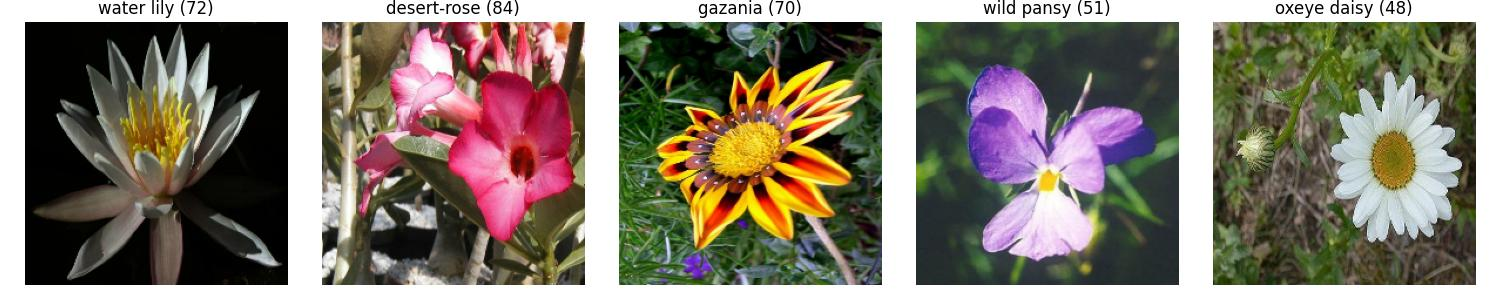

In [4]:
# @title Data
# use `as_supervised` to get the data in tuple (X,y) format
(ds_train, ds_test, ds_val), ds_info = tfds.load(
    "oxford_flowers102",
    with_info=True,
    as_supervised=True,
    split=["train", "test", "validation"],
)

images = get_images(ds_train)
show_images(images)

## RandAugment

[`RandAugment`](https://keras.io/api/keras_cv/layers/augmentation/rand_augment/) (Cubuk et al., [2019](https://arxiv.org/abs/1909.13719)) can be thought of as an all-in-one image augmentation layer. For each augmentation in range `[0, augmentations_per_image]`, sample a random number and if less than `rate`, apply the operation to the image. Also see the [guide](https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/).

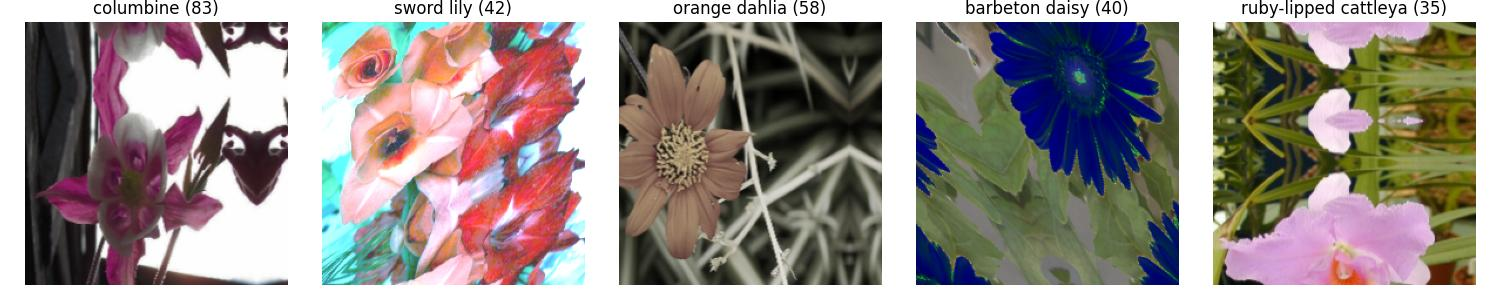

In [5]:
rand_augment = layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.5,
    magnitude_stddev=0.15,
    rate=10 / 11,
    geometric=True,  # set to False when performing object detection
    seed=42,
)

COUNTER += 1
images = get_images(ds_train)
images_rand_augment = images.map(rand_augment)

show_images(images_rand_augment)

## AugMix

[AugMix](https://keras.io/api/keras_cv/layers/augmentation/aug_mix/) (Hendrycks et al., [2019](https://arxiv.org/abs/1912.02781)) aims to produce images with variety while preserving the image semantics and local statistics. Each image is augmented `num_chains` different ways, each way consisting of `chain_depth` augmentations. Augmentations are sampled from:
* translation
* shearing
* rotation
* posterization
* histogram equalization
* solarization
* auto contrast

The results of each chain are mixed together with the original image based on random samples from a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Also see the official [repo](https://github.com/google-research/augmix) from Google.

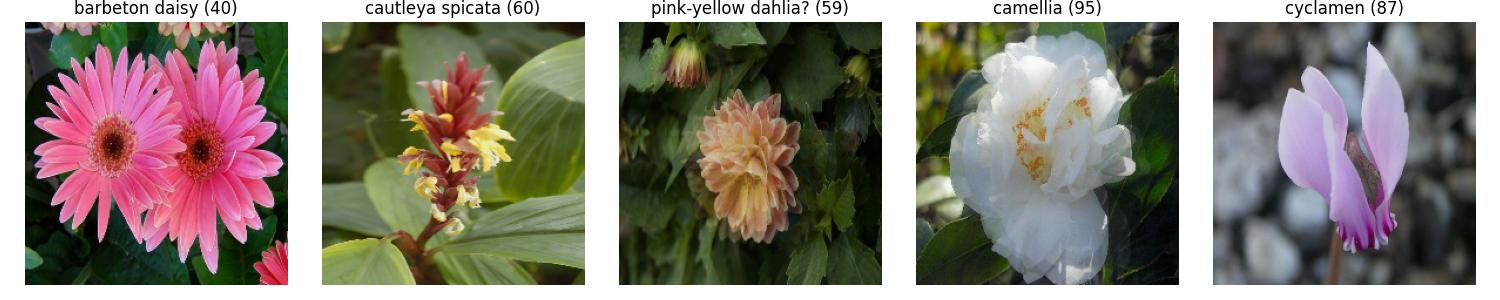

In [6]:
augmix = layers.AugMix(
    value_range=(0, 255),
    severity=(0.3, 0.6),
    num_chains=3,
    chain_depth=range(1, 4),
    alpha=1.0,
)

COUNTER += 1
images = get_images(ds_train)
images_augmix = images.map(augmix)

show_images(images_augmix)

## CutMix

[CutMix](https://keras.io/api/keras_cv/layers/augmentation/cut_mix/) (Yun et al., [2019](https://arxiv.org/abs/1905.04899)) patches are cut and pasted among training images where the ground truth labels are also mixed proportionally to the area of the patches. Also see the [guide](https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/) and original [PyTorch implementation](https://github.com/clovaai/CutMix-PyTorch).

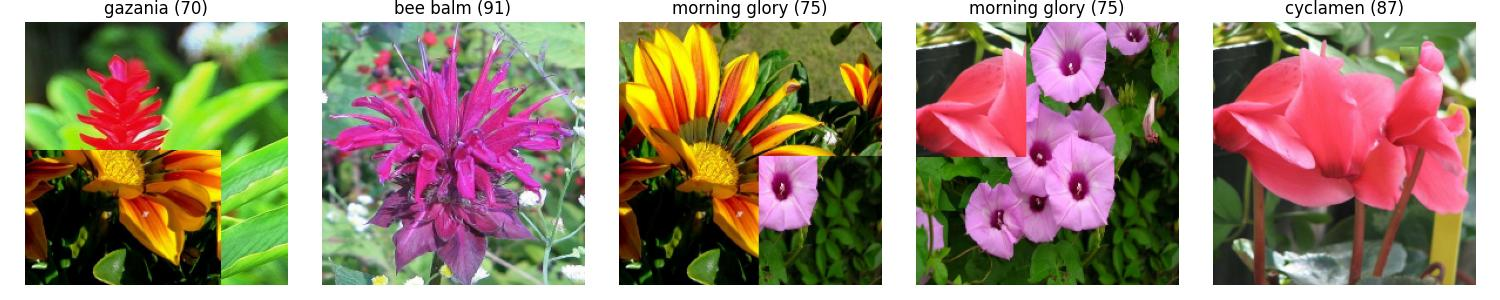

In [7]:
cutmix = layers.CutMix(
    alpha=1.0,
    seed=42,
)

COUNTER += 1
images = get_images(ds_train)
images_cutmix = images.map(cutmix)

show_images(images_cutmix)

## FourierMix

[FourierMix](https://keras.io/api/keras_cv/layers/augmentation/fourier_mix/) (Harris et al., [2020](https://arxiv.org/abs/2002.12047)) uses random binary masks obtained by applying a threshold to low frequency images sampled from Fourier space. These random masks can take on a wide variety of shapes. See the official [repo](https://github.com/ecs-vlc/FMix).

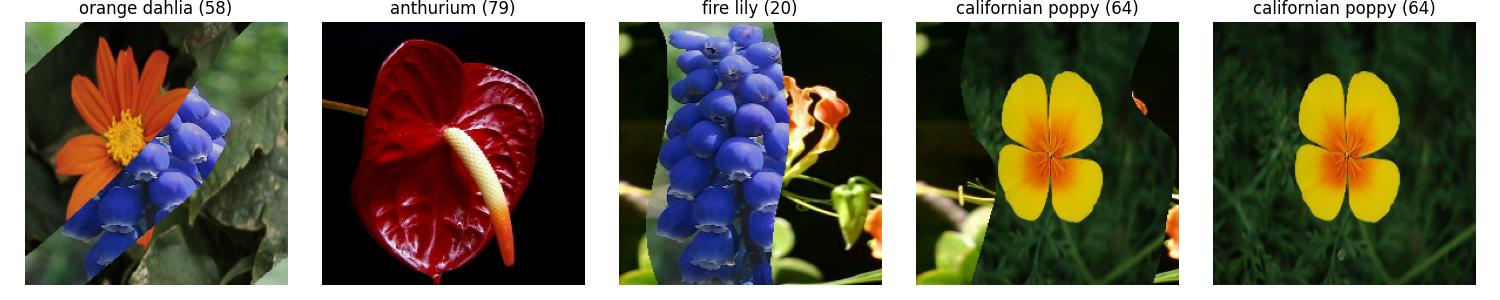

In [8]:
fourier_mix = layers.FourierMix(
    alpha=0.5,
    decay_power=3,
    seed=42,
)

COUNTER += 1
images = get_images(ds_train)
images_fourier_mix = images.map(fourier_mix)

show_images(images_fourier_mix)

## GridMask

[GridMask](https://keras.io/api/keras_cv/layers/augmentation/grid_mask/) (Chen et al., [2020](https://arxiv.org/abs/2001.04086)) performs information dropping by deleting regions of the image based on a grid pattern.

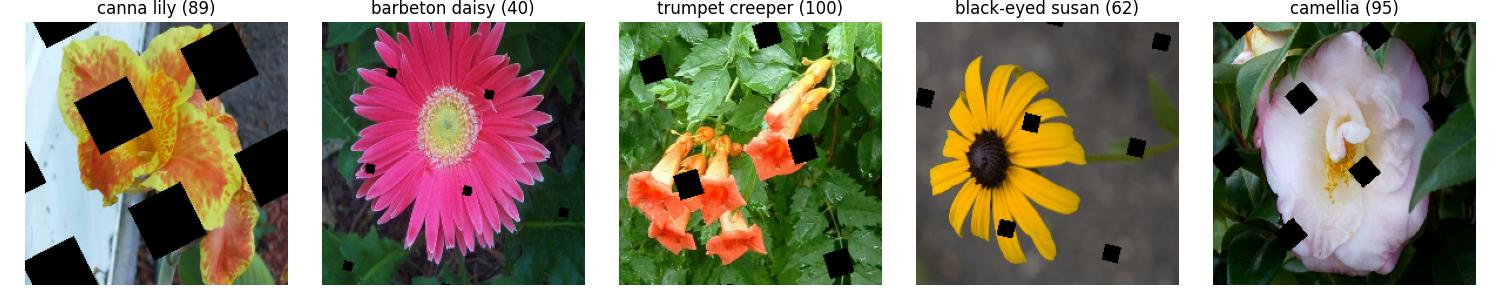

In [9]:
grid_mask = layers.GridMask(
    ratio_factor=(0, 0.5),
    rotation_factor=0.15,
    fill_mode="constant",
    fill_value=0.0,
    seed=42,
)

COUNTER += 1
images = get_images(ds_train)
images_grid_mask = images.map(grid_mask)

show_images(images_grid_mask)